In [464]:
import pandas as pd
import numpy as np
from math import pi

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

from eda_helpers import normality_check, count_outliers
from stat_inference_helpers import custom_corr, evaluate_model

In [465]:
data_info = pd.read_parquet("./data/data_info.parquet")
data = pd.read_csv("./data/data_train.csv")
results = pd.read_parquet("./data/results.parquet")

There is a lot of room for improvement. First, let's check if it will improve the model to add Longitude and Latitude features as 'Distance from the city center'. Most popular formulas for calculating diistance between 2 points are Euclidean and Manhattan distance. There is also Haversine formula to count distance between 2 poins on the map having their latitude and longitude. Let's count 3 of them and defice which correlates better with the Target:

**Haversine formula**:

a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)

c = 2 ⋅ atan2( √a, √(1−a) )

d = R ⋅ c

where φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);

**Euclidean distance**:

d = √[(φ1 - φ2)² + (λ1 - λ2)²]

**Manhattan distance**:

d = |φ1 - φ2| + |λ1 - λ2|

In [466]:
data2 = data.copy().drop(columns=['Address', 'Zip', 'Price per sqm'])
data2

,Price,Area,Room,Lon,Lat,Zip region
0,385000.0,49,3,4.938408,52.365552,0.0
1,930000.0,123,4,4.894206,52.338220,0.0
2,500000.0,70,3,4.869195,52.380747,0.0
3,400000.0,107,6,4.795810,52.376916,0.0
4,475000.0,98,4,4.838520,52.379072,0.0
...,...,...,...,...,...,...
732,1025000.0,135,4,4.875881,52.347368,0.0
733,915000.0,88,5,4.887412,52.377742,0.0
734,690000.0,100,3,4.881116,52.393955,0.0
735,450000.0,60,4,4.928173,52.355788,0.0


In [467]:
center_lat = data2['Lat'].mean()
center_lon = data2['Lon'].mean()

In [468]:
def distance_betw_2points(point_lat: float, center_lat: float, point_lon: float, center_lon: float, method: str = 'Euclidean') -> float:

    if method in ['Euclidean', 'Manhattan', 'Haversine']:

        if method == 'Euclidean':

            d = np.sqrt(np.square(center_lat - point_lat) + np.square(center_lon - point_lon))
            return d

        elif method == 'Haversine':
        
            # φ, λ in radians
            center_lat = center_lat * pi/180
            center_lon = center_lon * pi/180

            point_lat = point_lat * pi/180
            point_lon = point_lon * pi/180
            delta_lat = np.abs(point_lat - center_lat)
            delta_lon = np.abs(point_lon - center_lon)


            R = 6371e3 # in meters
            a = np.square(np.sin(delta_lat/2)) + np.cos(point_lat) * np.cos(center_lat) * np.square(np.sin(delta_lon/2))
            c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
            d = R * c

            return d
        
        else:

            d = np.abs(center_lat - point_lat) + np.abs(center_lon - point_lon)
            return d  
        
    else: 
        print('Method not in [Euclidean, Manhattan, Haversine]')

In [469]:
# generate distance features
data2 = data2.assign(
    **{
        "Euclidean_distance": lambda df: distance_betw_2points(
            df["Lat"], center_lat, df["Lon"], center_lon, method='Euclidean'
        ),
        "Manhattan_distance": lambda df: distance_betw_2points(
            df["Lat"], center_lat, df["Lon"], center_lon, method='Manhattan'
        ),
        "Haversine_distance": lambda df: distance_betw_2points(
            df["Lat"], center_lat, df["Lon"], center_lon, method='Haversine'
        )
    }
)

data2.head()

,Price,Area,Room,Lon,Lat,Zip region,Euclidean_distance,Manhattan_distance,Haversine_distance
0,385000.0,49,3,4.938408,52.365552,0.0,0.048844,0.051544,3325.501444
1,930000.0,123,4,4.894206,52.338220,0.0,0.024972,0.029115,2747.606908
2,500000.0,70,3,4.869195,52.380747,0.0,0.027226,0.038423,2433.520067
3,400000.0,107,6,4.795810,52.376916,0.0,0.094894,0.107977,6561.761428
4,475000.0,98,4,4.838520,52.379072,0.0,0.053659,0.067423,3915.516501


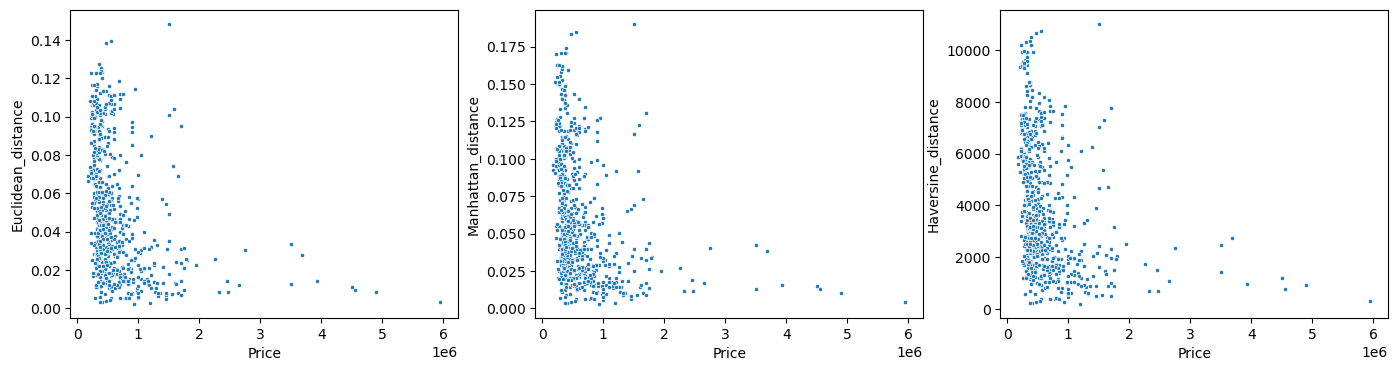

In [470]:
fig, axes = plt.subplots(1, 3, figsize=(17, 4))
for count, feature in enumerate(data2.columns[-3:]):
    sns.scatterplot(data = data2, x = 'Price', y = feature, marker='.', ax = axes.flatten()[count])

In [471]:
# in order to get correlations, we have to know the type of distribution of new features

data_info.loc['Euclidean_distance', 'data_type'] = 'continuous'
data_info.loc['Manhattan_distance', 'data_type'] = 'continuous'
data_info.loc['Haversine_distance', 'data_type'] = 'continuous'
data_info.loc['Euclidean_distance', 'missing values'] = 0
data_info.loc['Manhattan_distance', 'missing values'] = 0
data_info.loc['Haversine_distance', 'missing values'] = 0

normality_check(data = data2, data_info = data_info, features=data2.columns[-3:])

,data_type,missing values,distribution,n outliers
index,,,,
Price,continuous,3.0,right_skewed,0.0
Address,text,0.0,not applicable,0.0
Zip,text,0.0,not applicable,0.0
Area,continuous,0.0,right_skewed,0.0
Room,descrete,0.0,right_skewed,0.0
Lon,continuous,0.0,normal,3.0
Lat,continuous,0.0,heavy_tailed,3.0
Price per sqm,continuous,0.0,right_skewed,0.0
Zip region,descrete,0.0,not normal,NaN


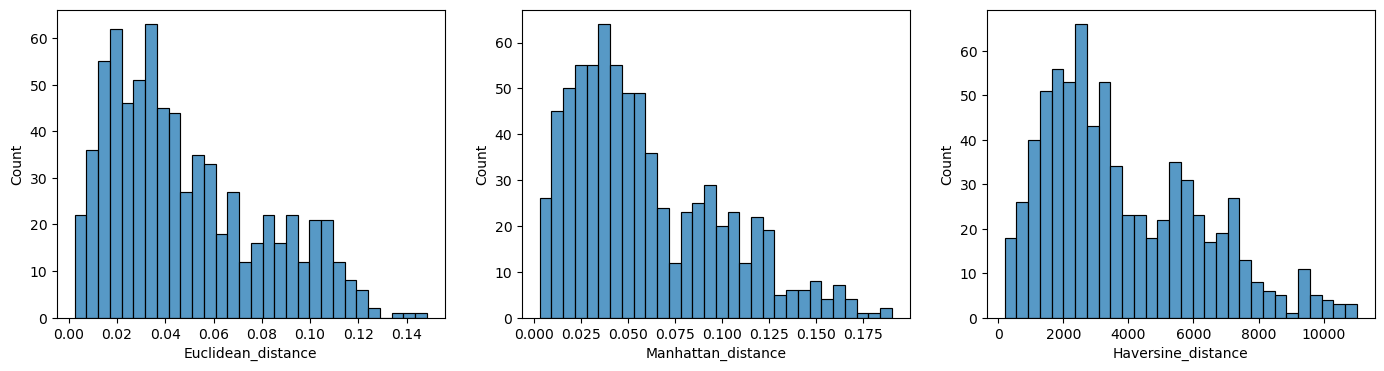

In [472]:
# because the distribution is not normal, lets plot it and manualy define the subtype, which is needed to find the outliers:

fig, axes = plt.subplots(1, 3, figsize = (17,4))
for count, feature in enumerate(data_info[-3:].index):
    sns.histplot(x = data2[feature], bins = 30, ax = axes.flatten()[count])

**All 3 destributions are deffinitely right-skewed**

In [473]:
for feature in data_info[-3:].index:
    data_info.loc[feature, 'distribution'] = 'right_skewed'

In [474]:
count_outliers(data2, data_info, ['Euclidean_distance', 'Manhattan_distance', 'Haversine_distance'])

o 2 datapoints with Euclidean_distance > 0.1385037944949909


,Price,Area,Room,Lon,Lat,Zip region,Euclidean_distance,Manhattan_distance,Haversine_distance
108,549001.0,107,4,5.016522,52.305075,1.0,0.139381,0.184576,10746.212739
422,1495000.0,214,5,5.029122,52.413550,0.0,0.148434,0.190256,11021.557352


o 3 datapoints with Manhattan_distance > 0.17417034684342658


,Price,Area,Room,Lon,Lat,Zip region,Euclidean_distance,Manhattan_distance,Haversine_distance
108,549001.0,107,4,5.016522,52.305075,1.0,0.139381,0.184576,10746.212739
377,475000.0,118,5,5.015376,52.305296,1.0,0.138247,0.183209,10669.091053
422,1495000.0,214,5,5.029122,52.413550,0.0,0.148434,0.190256,11021.557352


o 1 datapoints with Haversine_distance > 10941.469682701776


,Price,Area,Room,Lon,Lat,Zip region,Euclidean_distance,Manhattan_distance,Haversine_distance
422,1495000.0,214,5,5.029122,52.41355,0.0,0.148434,0.190256,11021.557352


Point with index 7 is an outlier by all 3 metrics because it is  way too fat from the city center. Lets remove it.

In [475]:
data2 = data2.drop([422], axis=0)
data = data.drop([422], axis=0)

# reset indexes after removing rows
data2 = data2.reset_index()
data2 = data2.drop(columns=['index'])

data = data.reset_index()
data = data.drop(columns=['index'])


data2 = data2.drop(columns=['Area', 'Lat', 'Lon'])

In [476]:
data2

,Price,Room,Zip region,Euclidean_distance,Manhattan_distance,Haversine_distance
0,385000.0,3,0.0,0.048844,0.051544,3325.501444
1,930000.0,4,0.0,0.024972,0.029115,2747.606908
2,500000.0,3,0.0,0.027226,0.038423,2433.520067
3,400000.0,6,0.0,0.094894,0.107977,6561.761428
4,475000.0,4,0.0,0.053659,0.067423,3915.516501
...,...,...,...,...,...,...
731,1025000.0,4,0.0,0.020657,0.029167,1951.290279
732,915000.0,5,0.0,0.015135,0.017201,1671.450185
733,690000.0,3,0.0,0.032328,0.039710,3515.356621
734,450000.0,4,0.0,0.039157,0.045514,2729.258426


In [477]:
custom_corr(data2, data_info, data2.columns)

,method,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman,Price,Room,0.517123,1.433085e-51,True,736
1,Spearman,Price,Zip region,-0.373103,1.003721e-25,True,736
2,Spearman,Price,Euclidean_distance,-0.452829,1.716699e-38,True,736
3,Spearman,Price,Manhattan_distance,-0.468180,2.291118e-41,True,736
4,Spearman,Price,Haversine_distance,-0.452968,1.619340e-38,True,736
5,Spearman,Room,Zip region,0.042842,2.457151e-01,False,736
6,Spearman,Room,Euclidean_distance,0.151764,3.561376e-05,True,736
7,Spearman,Room,Manhattan_distance,0.142645,1.031104e-04,True,736
8,Spearman,Room,Haversine_distance,0.153918,2.745515e-05,True,736
9,Spearman,Zip region,Euclidean_distance,0.433951,3.753533e-35,True,736


Here we can see, that Manhattan_distance has the strongest correlation with the target. It is also correlated with the 'Zip region', however the impact of Manhattan_distance on the target is stronger, so at this point we **remove the following features:**
 - Euclidean_distance
 - Haversine_distance
 - Zip region

In [478]:
data2 = data2.drop(columns=['Euclidean_distance', 'Haversine_distance', 'Zip region'])

In [479]:
# In order to make both features have equal impact, the log() function is applied to Manhattan_distance:
data2['log(Manhattan_distance)'] = np.log(data2['Manhattan_distance'])


In [480]:
X2 = data2.drop(columns=['Price', 'Manhattan_distance'])
y2 = np.log(data2['Price'])

model2 = LinearRegression()
model2.fit(X2, y2)
y_pred2 = model2.predict(X2)

y_pred2 = np.exp(y_pred2)

In [481]:
rmse2, mae2, r_value2, corr2 = evaluate_model('Linear Regression', list(X2.columns), 'log(Price)', data2['Price'], y_pred2, results)
results

,Model,List of used features,Target,RMSE,MAE,r_value,corr_coef
0,Linear Regression,"[Zip region, log(Area)]",log(Price),325388.852788,159374.459167,0.642526,0.813826
1,Linear Regression,"[Room, log(Manhattan_distance)]",log(Price),348662.518890,176088.758049,0.585887,0.750921


# Model with price per sqm

The assumption here is that the price per squre meter can be easier to predict. The logerithm of actions is the following:
1. Use price per sqm as a target
2. As features use different sets of [Area, Room, Distance] features
3. Predicted price per sqm multiply by Area and get final Price of the house
4. Measure model accuracy

In [482]:
data3 = pd.DataFrame()
data3['Price'] = data['Price']
data3['Price per sqm'] = data['Price per sqm']
data3['Area'] = data['Area']
data3['Room'] = data['Room']
data3['Manhattan_distance'] = data2['Manhattan_distance']
data3


,Price,Price per sqm,Area,Room,Manhattan_distance
0,385000.0,7857.142857,49,3,0.051544
1,930000.0,7560.975610,123,4,0.029115
2,500000.0,7142.857143,70,3,0.038423
3,400000.0,3738.317757,107,6,0.107977
4,475000.0,4846.938776,98,4,0.067423
...,...,...,...,...,...
731,1025000.0,7592.592593,135,4,0.029167
732,915000.0,10397.727273,88,5,0.017201
733,690000.0,6900.000000,100,3,0.039710
734,450000.0,7500.000000,60,4,0.045514


In [483]:
custom_corr(data3, data_info, features=['Price per sqm', 'Manhattan_distance', 'Room', 'Area'])

,method,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman,Price per sqm,Manhattan_distance,-0.802376,1.078904e-166,True,736
1,Spearman,Price per sqm,Room,-0.234372,1.215174e-10,True,736
2,Spearman,Price per sqm,Area,-0.219360,1.805924e-09,True,736
3,Spearman,Manhattan_distance,Room,0.142645,1.031104e-04,True,736
4,Spearman,Manhattan_distance,Area,0.069462,5.962902e-02,False,736
5,Spearman,Room,Area,0.772415,7.512523e-147,True,736


Room corralates with Area and Manhattan_distance that is why it will be removed

In [484]:
# create features and target to feed to model
X3 = data3.drop(columns=['Price per sqm', 'Price', 'Room'])
y3 = np.log(data3['Price per sqm'])
# y3 = data3['Price per sqm']

# create model
model3 = LinearRegression()
model3.fit(X3, y3)

pred_log_price_sqm = model3.predict(X3)
pred_price_sqm = np.exp(pred_log_price_sqm)
pred_price = pred_price_sqm * data3['Area'] 

In [485]:
rmse3, mae3, r_value3, corr3 = evaluate_model('Linear Regression', list(X3.columns), 'log(Price per sqm)', data3['Price'], pred_price, results)
results

,Model,List of used features,Target,RMSE,MAE,r_value,corr_coef
0,Linear Regression,"[Zip region, log(Area)]",log(Price),325388.852788,159374.459167,0.642526,0.813826
1,Linear Regression,"[Room, log(Manhattan_distance)]",log(Price),348662.518890,176088.758049,0.585887,0.750921
2,Linear Regression,"[Area, Manhattan_distance]",log(Price per sqm),226039.024618,102747.579333,0.824916,0.910482
